# Recession Indicators
Brian Howard
21 April 2019

In [1]:
library(UsingR)
library(quantmod)
library(ggplot2)
library(grid)
library(gridExtra)
library(knitr)
library(kableExtra)
library(tools)
library(zoo)
library(signal)
library(stringr)
library(corrplot)
library(caret)
library(rpart)
library(rpart.plot)
library(randomForest)
library(Quandl)
library(nnet)
#library(devtools)
#install_github("andrewuhl/RollingWindow")
library(RollingWindow)
library(gtable)
library(data.table)
library(readxl)

Loading required package: MASS
Loading required package: HistData
Loading required package: Hmisc
Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: 'Hmisc'

The following objects are masked from 'package:base':

    format.pval, units


Attaching package: 'UsingR'

The following object is masked from 'package:survival':

    cancer

Loading required package: xts
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Loading required package: TTR
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Version 0.4-0 included new data defaults. See ?getSymbols.

Attaching package: 'quantmod'

The following object is masked from 'package:Hmisc':

    Lag


Attaching package: 'sign

Call helper functions

In [2]:
source("plotHelper.r")

Define the source of the data (local or web) and whether to update the models.

In [3]:
b.refresh.models = FALSE

Define the plotting ranges

In [4]:
dt.recent = as.Date("2017-01-01")

Load up the off-line data

In [5]:
load("C:/Users/Rainy/OneDrive//RecessionIndicator_Buffer.RData")

This snippet is needed because some of the ticker symbols include are invalid variable names so re-cast those variable names.

In [6]:
df.symbols$string.symbol <-
  str_replace_all(df.symbols$string.symbol, "[^[:alnum:]]", "")

Do the interpolation to daily samples and tidy the data

In [7]:
source("calcInterpolate.r")

In [8]:
df.data <- calcInterpolate(df.data, df.symbols)

Warning message in merge.xts(xtsData, get(df.symbols$string.symbol[idx])):
"NAs introduced by coercion"

Create aggreagate data series
Some analysis requires that two or more series be combined. For example, normallizing debt by GDP to get a sense of the proportion of debt to the total economy helps understand the debt cycle.

In [9]:
source("calcAggregateSeries.r")

Calculate the year-over-year, 50 day moving average, and other features in the data

In [10]:
source("calcFeatures.r")

In [11]:
lst.df <- calcFeatures(df.data, df.symbols)
df.data <- lst.df[[1]]
df.symbols <- lst.df[[2]]

[1] "USREC has zero or negative values. Log series will be zero."
[1] "SRPSABSNNCB has zero or negative values. Log series will be zero."
[1] "TNX.Volume has zero or negative values. Log series will be zero."
[1] "DTB3 has zero or negative values. Log series will be zero."
[1] "IRX.Volume has zero or negative values. Log series will be zero."
[1] "GSPC.Volume has zero or negative values. Log series will be zero."
[1] "RLG.Volume has zero or negative values. Log series will be zero."
[1] "VXX.Volume has zero or negative values. Log series will be zero."
[1] "FYFSD has zero or negative values. Log series will be zero."
[1] "FYFSGDA188S has zero or negative values. Log series will be zero."
[1] "RPONTSYD has zero or negative values. Log series will be zero."
[1] "EES.Volume has zero or negative values. Log series will be zero."
[1] "VGSTX.Volume has zero or negative values. Log series will be zero."
[1] "VFINX.Volume has zero or negative values. Log series will be zero."
[1] "TMFGX.Volume

These are auxilliary series that use the YoY and smoothed data.

In [12]:
source("calcFeaturesAggregate.r")

Build the recession data frame

In [13]:
source("calcRecession.r")

In [14]:
source("calcRecession.r")

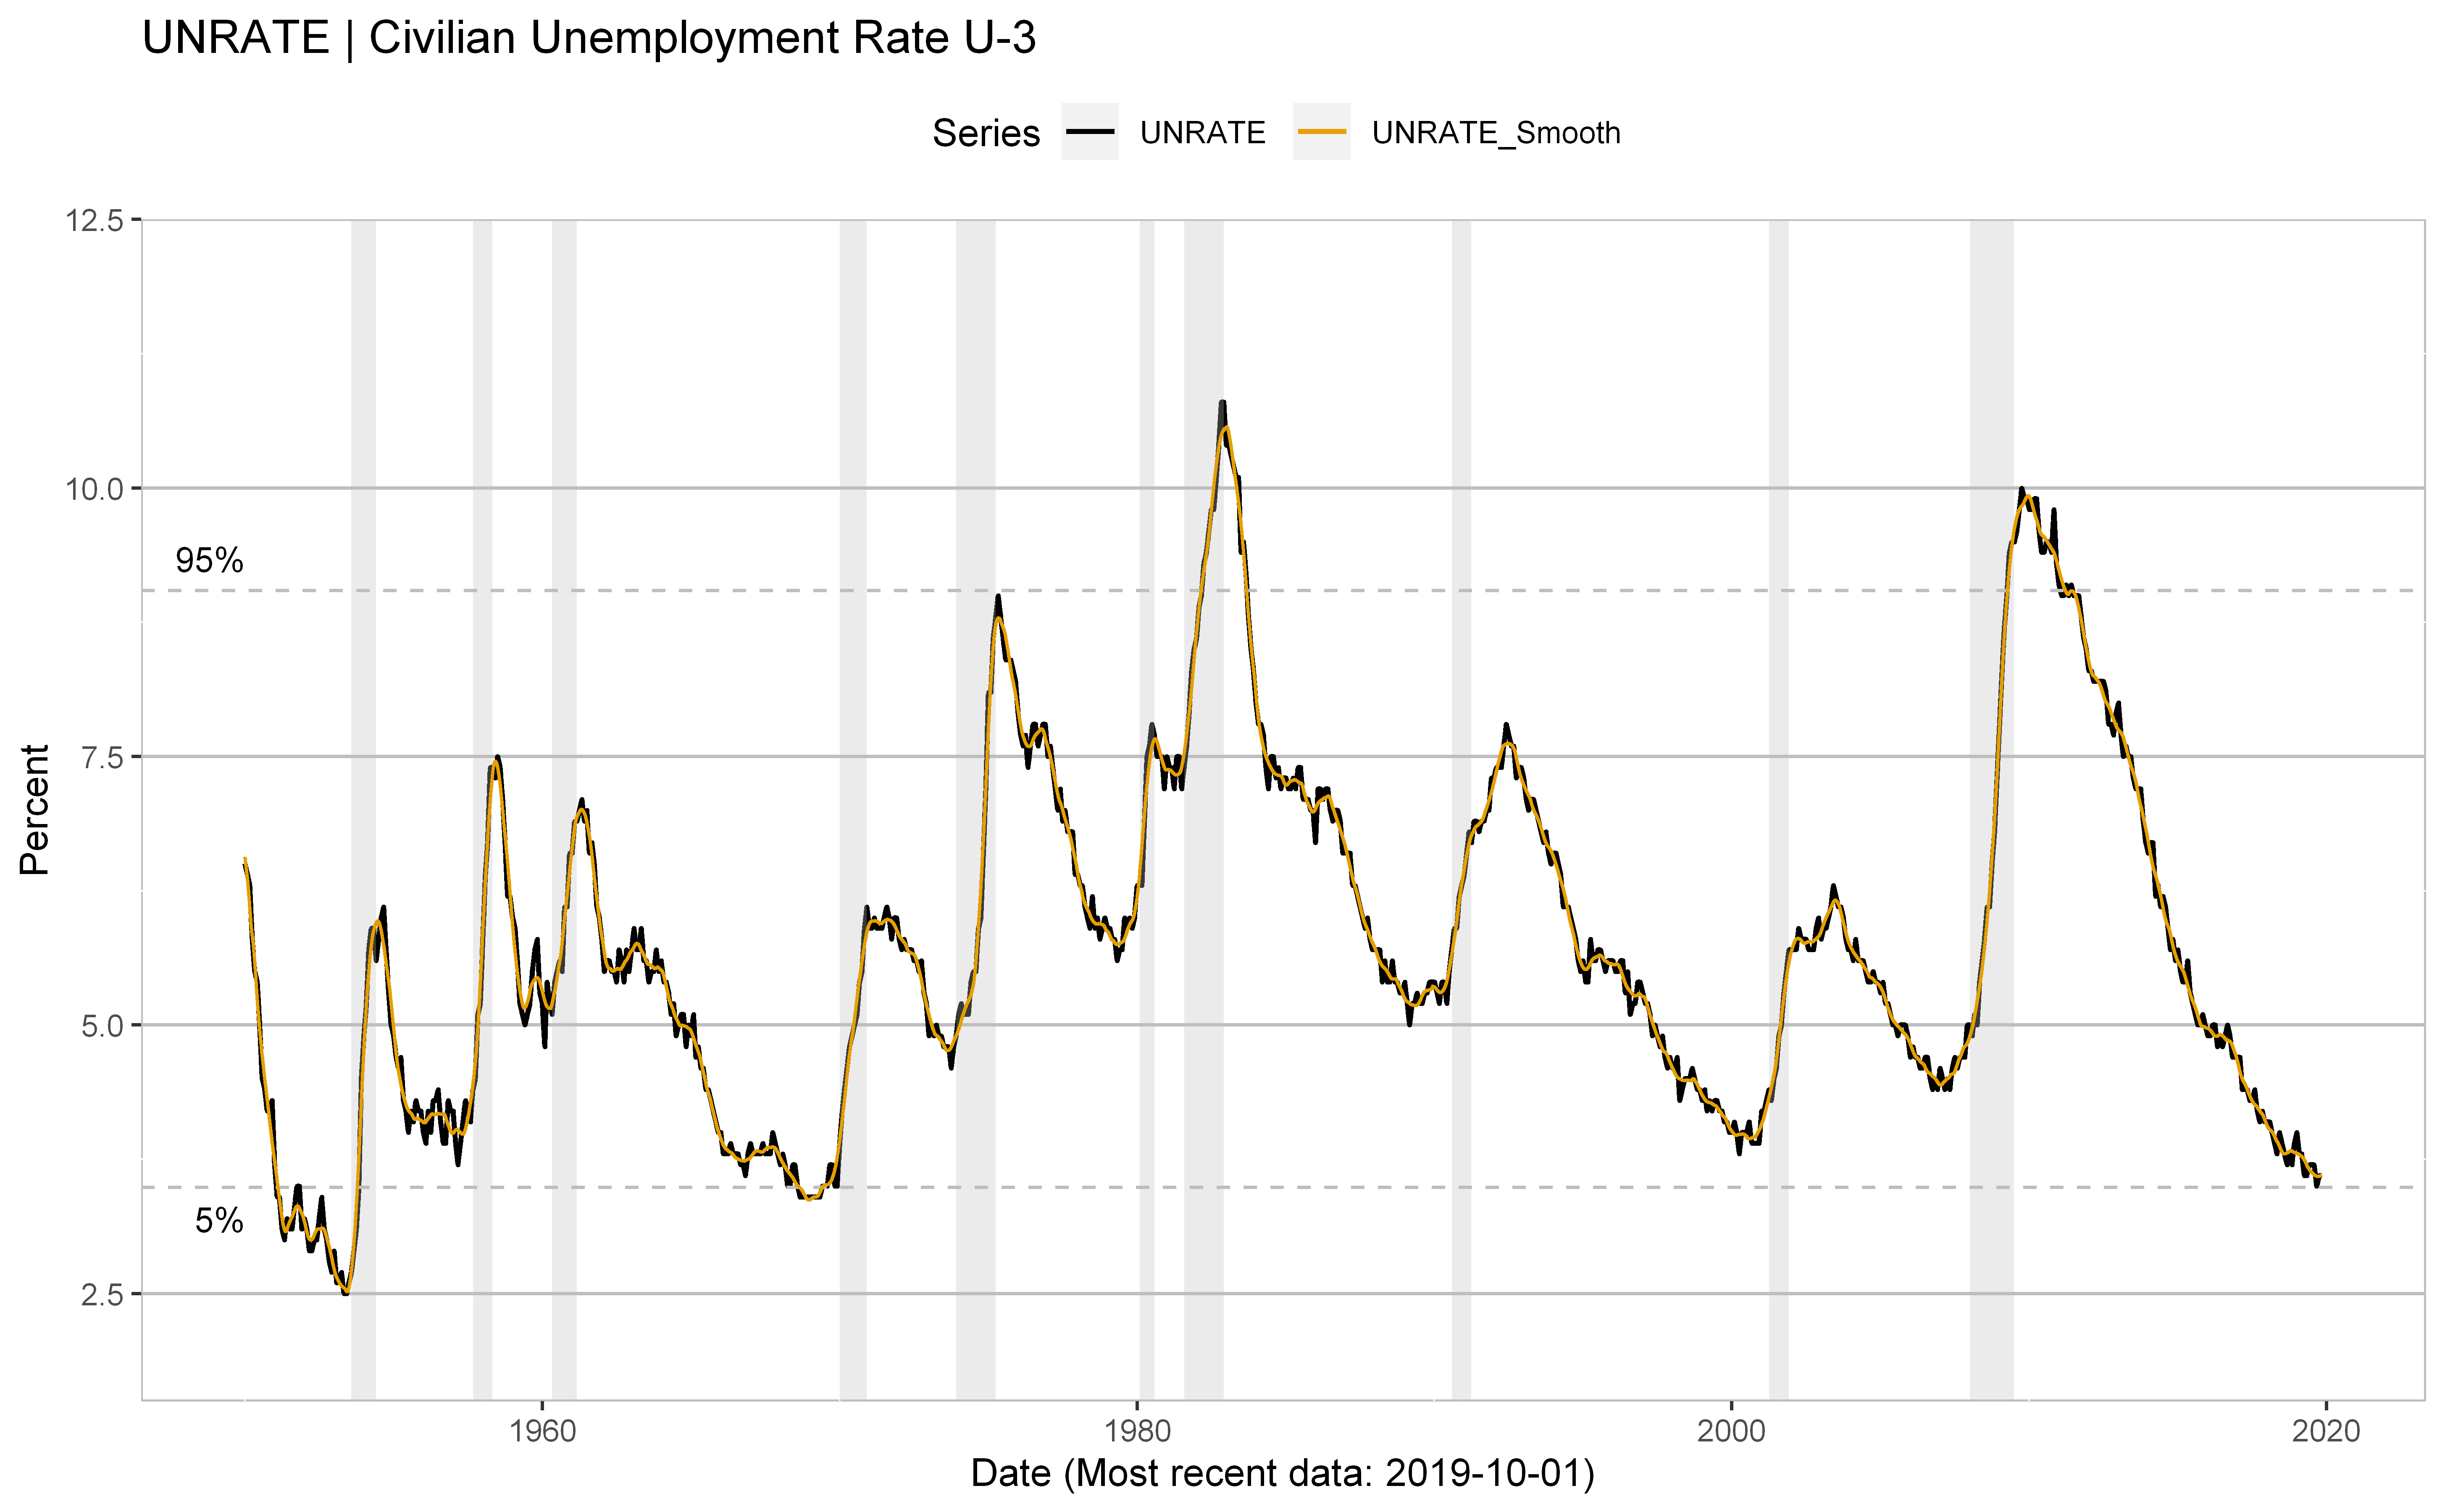

In [15]:
options(repr.plot.width = 9.7, repr.plot.height = 6, repr.plot.res = 600)
datay <- "UNRATE"
datay_aux <- "UNRATE_Smooth"
ylim <- c(2, 12)
b.legend <- TRUE
b.percentile <- TRUE
myPlot <- plotSingle(dfRecession, df.data, "date", datay, getPlotTitle(df.symbols, datay), "Date", 
            getPlotYLabel(df.symbols, datay), c(as.Date("1jan1950","%d%b%Y"), Sys.Date()), ylim, b.legend, b.percentile)
myPlot + geom_line(data=df.data, aes_string(x="date", y=datay_aux, colour=shQuote(datay_aux)), na.rm = TRUE)

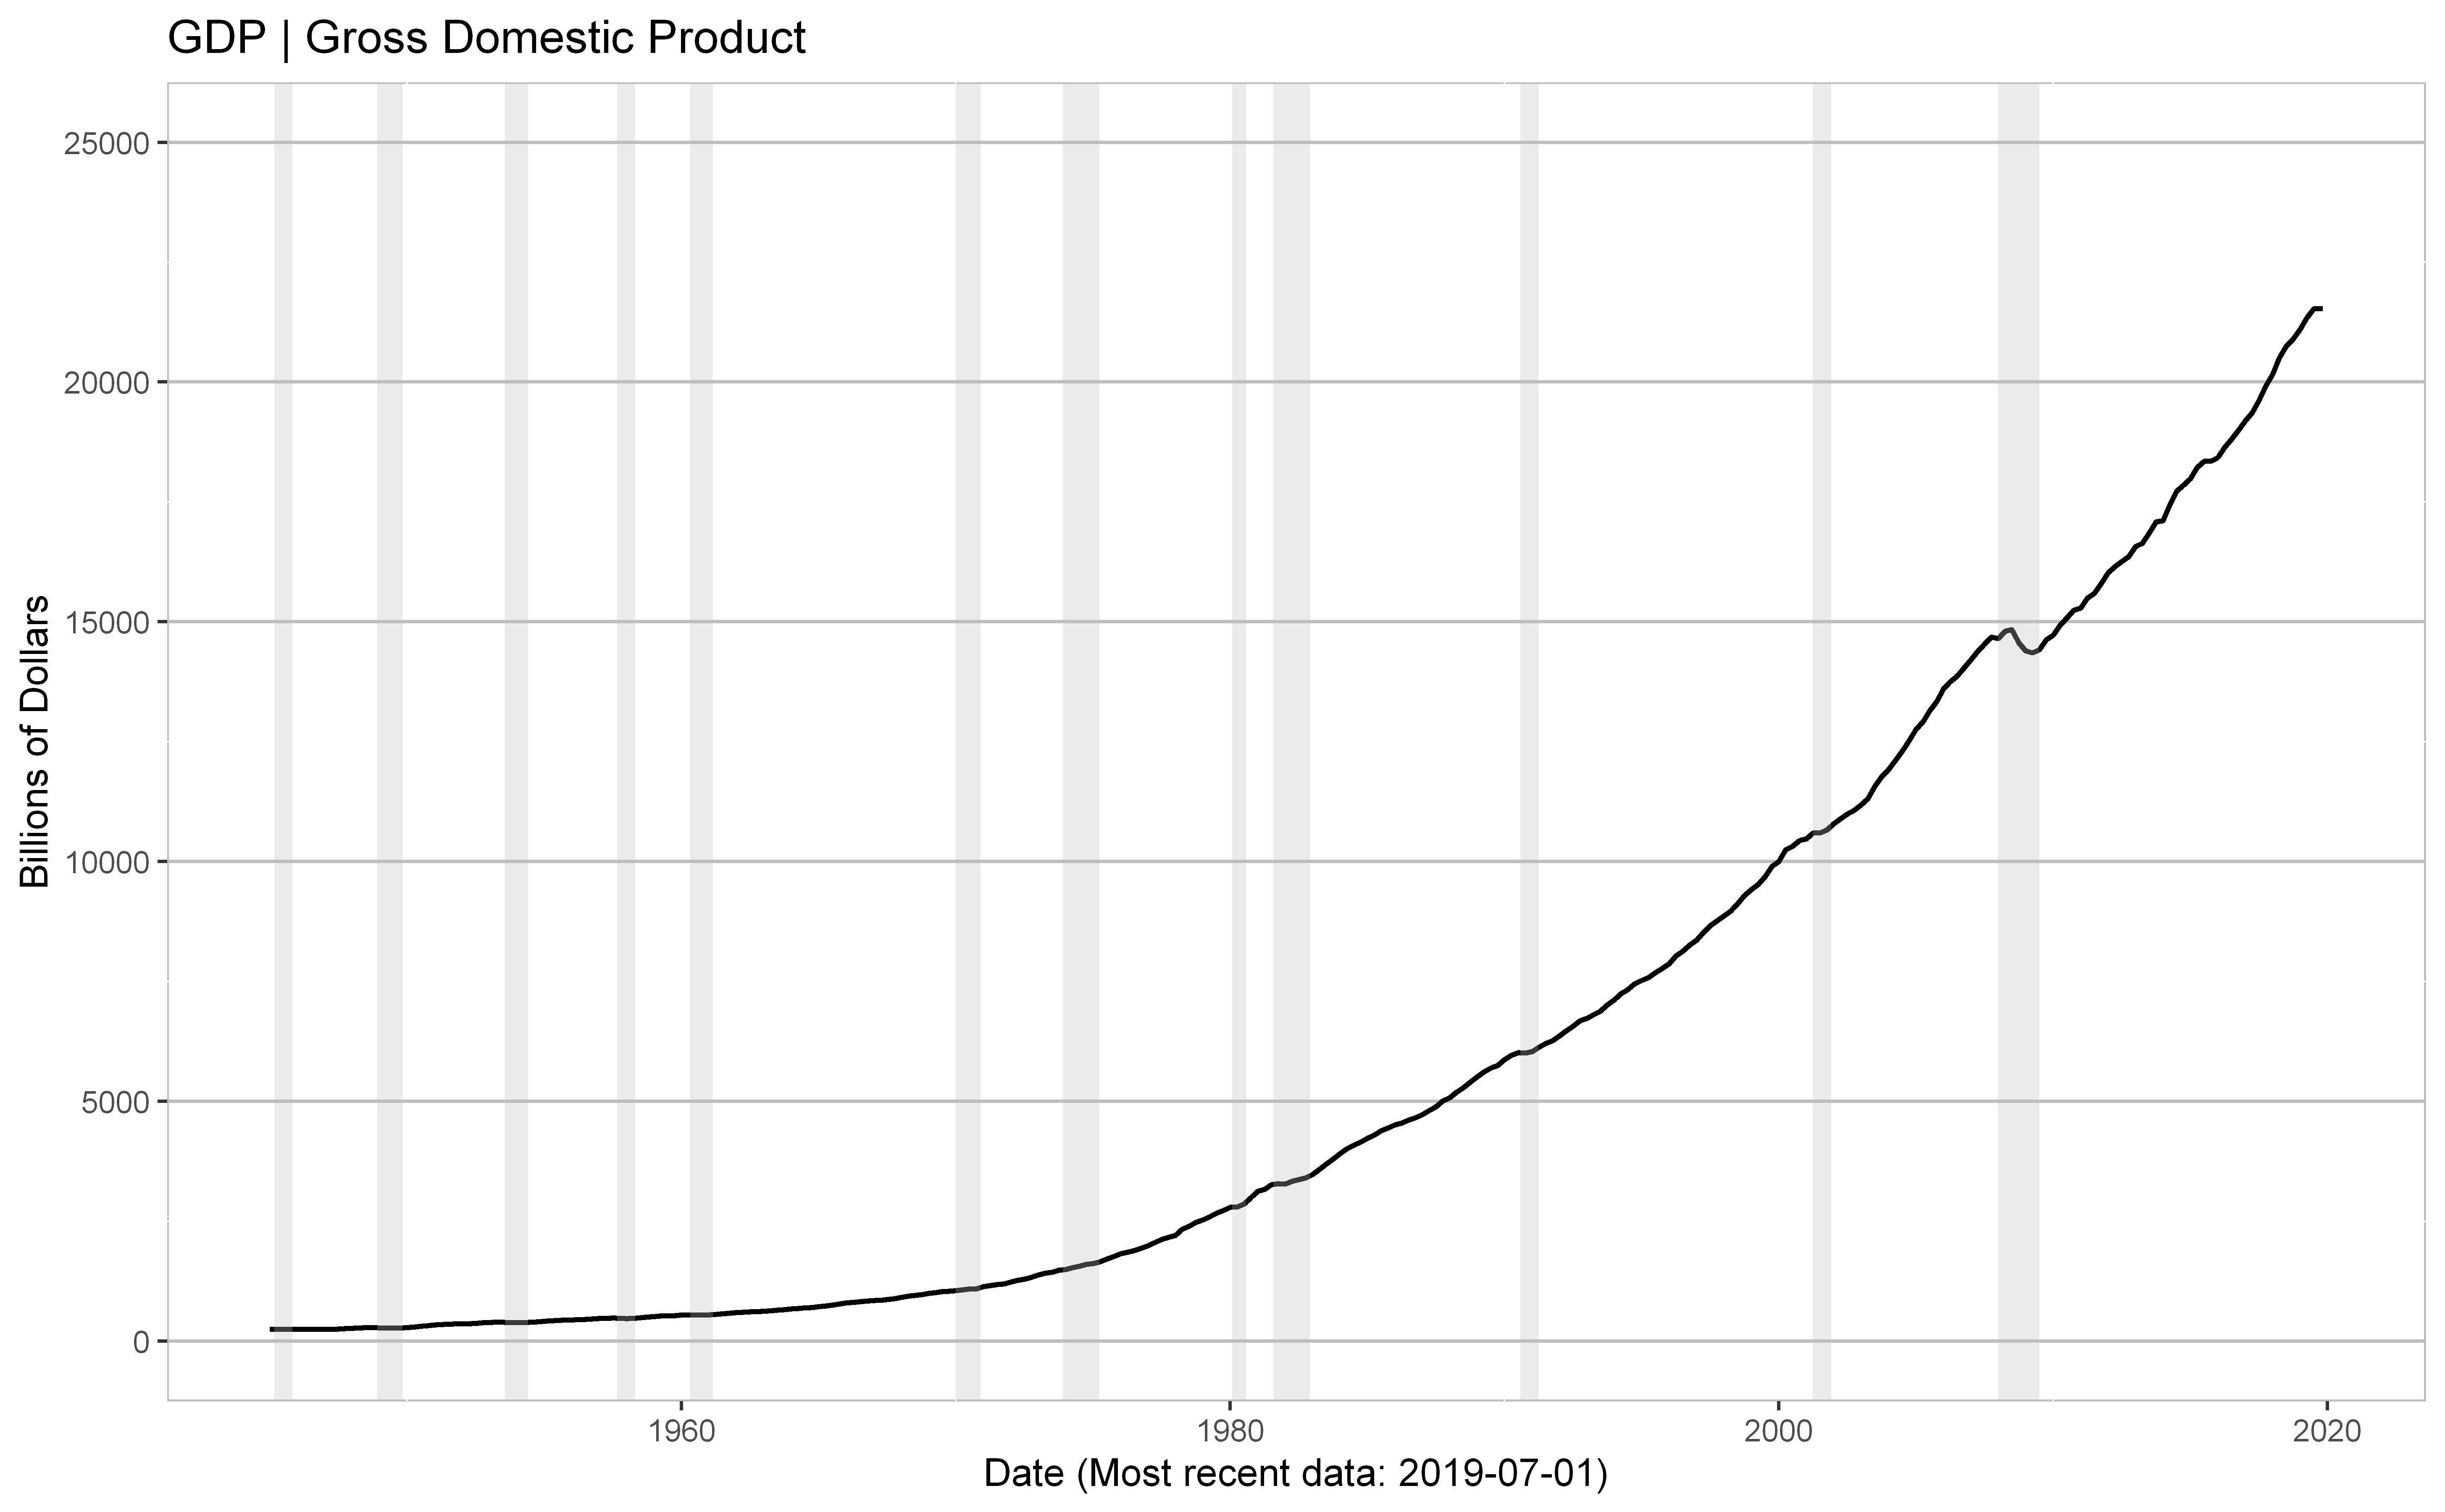

In [16]:
options(repr.plot.width = 9.7, repr.plot.height = 6, repr.plot.res = 600)
datay <- "GDP"
ylim <- c(1, 25000)
plotSingleQuick(dfRecession, df.data, datay, ylim)

In [17]:
df.data$CPROFIT.by.GDP <- (df.data$CPROFIT / df.data$GDP) * 100

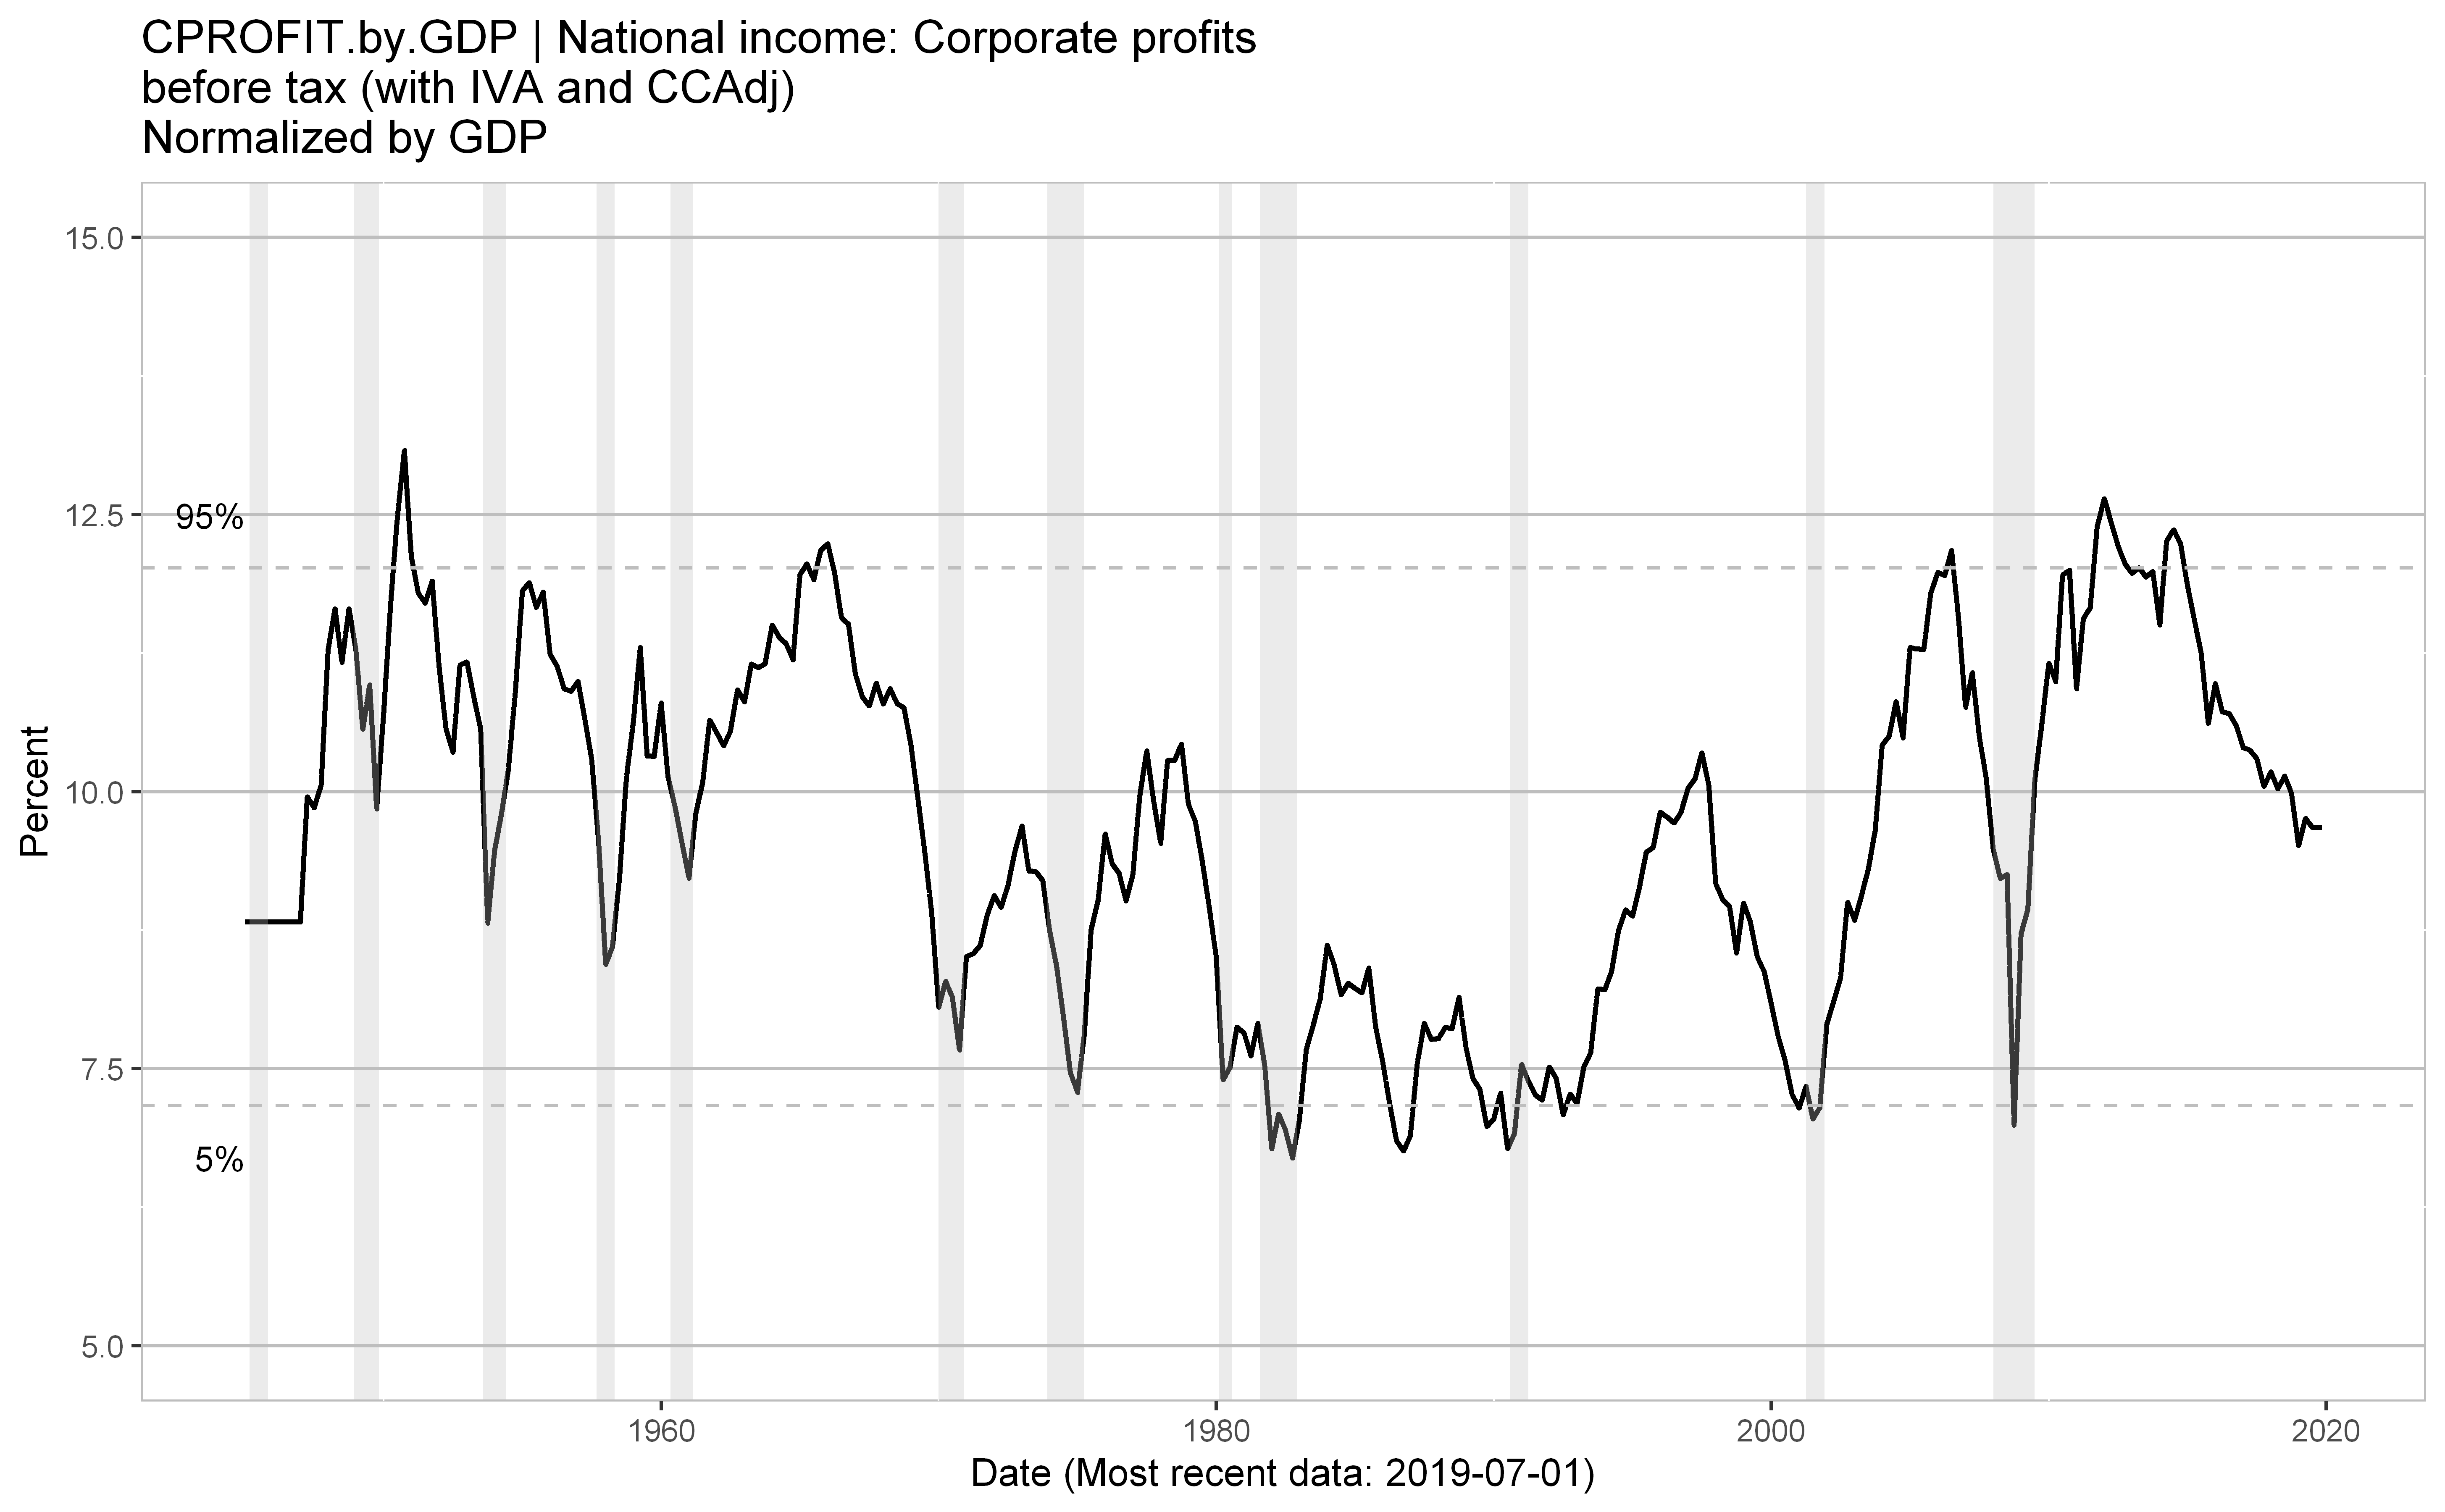

In [18]:
options(repr.plot.width = 9.7, repr.plot.height = 6, repr.plot.res = 600)
datay <- "CPROFIT.by.GDP"
ylim <- c(5, 15)
plotSingleQuick(dfRecession, df.data, datay, ylim, b.percentile = TRUE)

In [30]:
# Get S&P 500 Silverblatt data. From USDA website:
# https://us.spindices.com/documents/additional-material/sp-500-eps-est.xlsx

# Read in th Excel file
df.silverblatt <- data.frame(read_excel('sp-500-eps-est.xlsx', range='QUARTERLY DATA!A6:E133'))

# Human readable column names
colnames(df.silverblatt) <- c("QUARTER.END", "DIVISOR", "OP.EARNINGS.PER.SHARE", "AR.EARNINGS.PER.SHARE","CASH.DIVIDENDS.PER.SHR")

# Create the XTS object and update the symbols table
str.symbol <- 'OP.EARNINGS.PER.SHARE'
assign(str.symbol, xts(x=df.silverblatt$OP.EARNINGS.PER.SHARE, order.by=df.silverblatt$QUARTER.END))

df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol,
      string.source = "SILVERBLATT",
      string.description =  "Operating Earnings per Share",
      string.label.y = "Dollars",
      float.expense.ratio = -1.00,
      date.series.start = dt.date[1],
      date.series.end = tail(dt.date,1)
    )
  )


New names:
* `PER SHR` -> `PER SHR...3`
* `PER SHR` -> `PER SHR...4`
* `PER SHR` -> `PER SHR...5`


ERROR: Error in rbind(deparse.level, ...): numbers of columns of arguments do not match


In [29]:
OP.EARNINGS.PER.SHARE

Warning message:
"timezone of object (UTC) is different than current timezone ()."

            [,1]
1988-03-31  5.48
1988-06-30  6.05
1988-09-30  6.22
1988-12-31  6.37
1989-03-31  6.41
1989-06-30  6.53
1989-09-30  5.54
1989-12-31  5.84
1990-03-31  5.61
1990-06-30  6.06
1990-09-30  5.97
1990-12-31  5.01
1991-03-31  4.77
1991-06-30  4.79
1991-09-30  5.11
1991-12-31  4.63
1992-03-31  4.93
1992-06-30  5.21
1992-09-30  5.12
1992-12-31  5.61
1993-03-31  6.25
1993-06-30  6.57
1993-09-30  6.92
1993-12-31  7.16
1994-03-31  7.17
1994-06-30  7.75
1994-09-30  8.03
1994-12-31  8.80
1995-03-31  8.64
1995-06-30  9.50
1995-09-30  9.78
1995-12-31  9.78
1996-03-31  9.39
1996-06-30 10.31
1996-09-30  9.92
1996-12-31 11.01
1997-03-31 10.56
1997-06-30 11.13
1997-09-30 11.03
1997-12-31 11.29
1998-03-31 10.92
1998-06-30 11.43
1998-09-30 10.45
1998-12-31 11.47
1999-03-31 11.73
1999-06-30 13.21
1999-09-30 12.97
1999-12-31 13.77
2000-03-31 13.97
2000-06-30 14.88
2000-09-30 14.17
2000-12-31 13.11
2001-03-31 10.73
2001-06-30  9.02
2001-09-30  9.16
2001-12-31  9.94
2002-03-31 10.85
2002-06-30 11.

QUARTER.END,DIVISOR,OP.EARNINGS.PER.SHARE,AR.EARNINGS.PER.SHARE,CASH.DIVIDENDS.PER.SHR
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>
2019-09-30,8299.999,NA,NA,14.801734
2019-06-28,8302.338,40.14,34.93,14.242944
2019-03-29,8332.838,37.99,35.02,13.982722
2018-12-31,8387.788,35.03,28.96,14.192107
2018-09-28,8434.956,41.38,36.36,13.659502
2018-06-29,8474.313,38.65,34.05,13.102583
2018-03-29,8518.408,36.54,33.02,12.793987
2017-12-29,8535.739,33.85,26.96,12.782924
2017-09-30,8565.262,31.33,28.45,12.310797
